In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_test
import seis_invert
import seis_prior
#import seis_nn
import cupy as cp
import seis_diagnostics
import seis_forward2

maxcor
F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\unet2d_caformer_seed3_epochbest.pt
n_models: 1


In [2]:
data=kgs.load_all_train_data()
d = data[8011]
print(d.family)

Style_A


In [3]:
# importlib.reload(seis_prior)
# importlib.reload(seis_diagnostics)
# importlib.reload(seis_invert)
# kgs.profiling=False
# kgs.debugging_mode = 0
# seis_forward2.profiling=False
# seis_forward2.reset_profile()

# model = seis_invert.InversionModel()
# model.state = 1
# model.method = 'L-BFGS-B'
# model.maxiter = 5000
# model.prior = seis_prior.SquaredExponential()


# model.prior.basis_functions();
# w = cp.linalg.eigvalsh(model.prior.P)   
# plt.figure()
# plt.semilogy(cp.asnumpy(cp.abs(w)))

maxcor
False False
(4901, 4901)


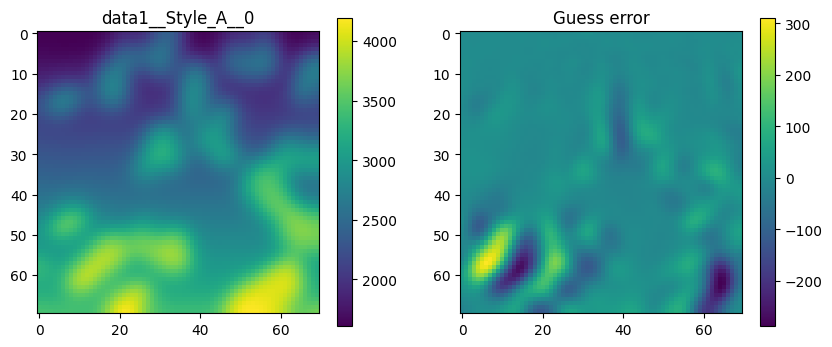

True False
(4901, 4901)
(4900, 4900)
7.696693718858792e-05 54.67348141943317
2.2062472366511634 331.1990205523918
7.682314217692996e-05 54.660267330141394
7.25707772385803e-05 54.666492809528584
7.25555244508559e-05 54.666583073064224
7.241903664250836e-05 54.667406284783574
7.113210688625811e-05 54.67671136192156
6.429349012067159e-05 54.92175132643192
6.304290560822393e-05 54.97328779138862
5.7583273469167884e-05 55.1615270109676
5.7567918066841434e-05 55.65970462778977
5.6018077589657624e-05 55.38962157294568
5.429730970799823e-05 55.30156844117952
5.218789801287758e-05 55.21403498994365
5.089820745165424e-05 55.12403191997632
5.0043779275319094e-05 55.32493499773856
4.889797280907146e-05 55.180857379514556
4.7664389952727874e-05 55.08323517689653
4.60890860625913e-05 54.97838436304466
4.405949777039975e-05 54.84459666007969
4.1632894976117546e-05 54.680092224651055
3.9820876256656476e-05 54.65685046843281
3.856571315858727e-05 54.61824006174523
3.724415701522343e-05 54.583514577336

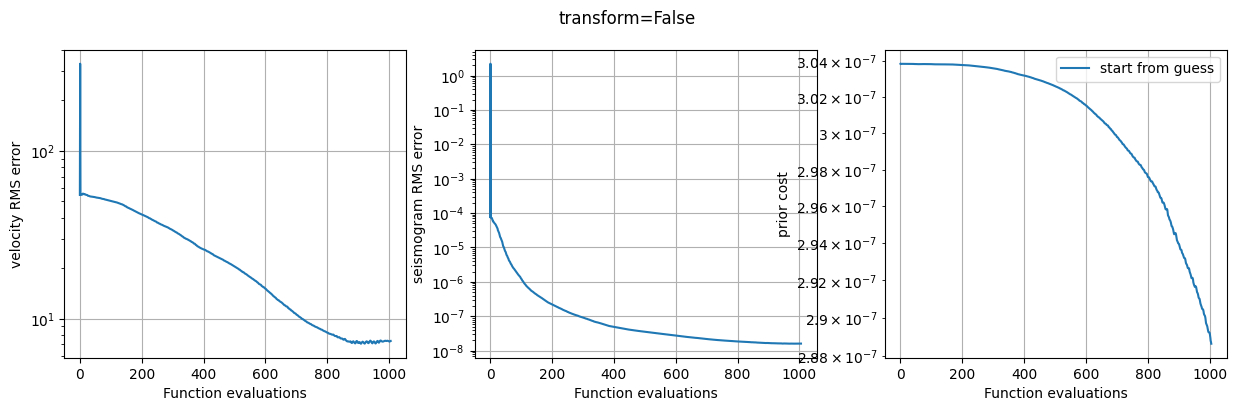

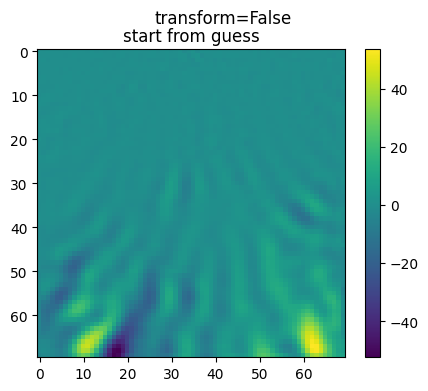

True True
(4901, 4901)
(4900, 4900)
7.696693718858792e-05 54.67348141943317
2.2062472366511634 331.1990205523918
7.682314217692996e-05 54.660267330141394
7.25707772385803e-05 54.666492809528584
7.25555244508559e-05 54.666583073064224
7.241903664250836e-05 54.667406284783574
7.113210688625811e-05 54.67671136192156
6.429349012067159e-05 54.92175132643192
6.304290560822393e-05 54.97328779138862
5.7583273469167884e-05 55.1615270109676
5.7567918066841434e-05 55.65970462778977
5.6018077589657624e-05 55.38962157294568
5.429730970799823e-05 55.30156844117952
5.218789801287758e-05 55.21403498994365
5.089820745165424e-05 55.12403191997632
5.0043779275319094e-05 55.32493499773856
4.889797280907146e-05 55.180857379514556
4.7664389952727874e-05 55.08323517689653
4.60890860625913e-05 54.97838436304466
4.405949777039975e-05 54.84459666007969
4.1632894976117546e-05 54.680092224651055
3.9820876256656476e-05 54.65685046843281
3.856571315858727e-05 54.61824006174523
3.724415701522343e-05 54.5835145773366

KeyboardInterrupt: 

In [19]:
importlib.reload(seis_prior)
importlib.reload(seis_diagnostics)
importlib.reload(seis_invert)
kgs.profiling=False
kgs.debugging_mode = 0
seis_forward2.profiling=False
seis_forward2.reset_profile()

# transform back on, history size to infinite, maxiter down
model = seis_invert.InversionModel()
model.state = 1
model.maxiter = 1000
model.history_size = 10000
model.prior = seis_prior.SquaredExponential()
model.prior.transform = False
model.prior.svd_cutoff = -np.inf
model.prior.λ = 10**-11
model.prior.basis_functions()
#KK = cp.pad(model.prior.K, ((0, 1), (0, 1)), mode='constant', constant_values=0)
#KK[-1,-1] = 10000.
U,s,_=cp.linalg.svd(model.prior.K,compute_uv=True)
model.prec_matrix = (U@cp.diag(cp.sqrt(s)))
model.prec_matrix = cp.pad(model.prec_matrix, ((0, 1), (0, 1)), mode='constant', constant_values=0)
model.prec_matrix[-1,-1] = 1.
#model.prior.use_full=True

do_which_list = [False,False,True]

def param_func(model,value):
    model.prior.transform = value
    return model
param_values = [False]
param_name = "transform"


for d in data[8000:8001]:
    results = seis_diagnostics.do_diagnostics_run(d, model, do_which_list, param_func, param_values, param_name)

In [7]:
%debug

> f:\seismic\code\analysis\cupy\_core\_routines_linalg.pyx(510)cupy._core._routines_linalg.dot()



ipdb>  u


> f:\seismic\code\analysis\cupy\_core\_routines_linalg.pyx(846)cupy._core._routines_linalg.matmul()



ipdb>  u


> f:\seismic\code\analysis\cupy\_core\core.pyx(1295)cupy._core.core._ndarray_base.__matmul__()



ipdb>  u


> f:\seismic\code\core\seis_prior.py(157)_compute_cost_and_gradient()
    155             cost = x.T@self.P@x
    156         else:
--> 157             cost = x[:-1,:].T@self.P@x[:-1,:]
    158         cost = cost[0,0]
    159 



ipdb>  sel.fP.shape


*** NameError: name 'sel' is not defined


ipdb>  self.P.shape


(4901, 4901)


ipdb>  q


In [ ]:
seis_forward2.show_profile(1)